# 물류 최적경로 컨설팅

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [18]:
factories = pd.read_csv('tbl_factory.csv', index_col=0) # 생산공장
warehouses = pd.read_csv('tbl_warehouse.csv', index_col=0) # 창고
cost = pd.read_csv('rel_cost.csv', index_col=0) # 창고와 생산공장 간 운송비용
trans = pd.read_csv('tbl_transaction.csv', index_col=0) # 생산공장으로의 부품 운송 실적

In [19]:
join_data = pd.merge(trans, cost, left_on=["ToFC", "FromWH"], right_on=["FCID", "WHID"], 
                    how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [20]:
join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", 
                    how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,수원공장,29,북부
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,서울공장,28,북부


In [21]:
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", 
                    how='left')
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 
                     'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,WH00002,용인창고,41,북부


In [22]:
north = join_data.loc[join_data['WHRegion']=='북부']
south = join_data.loc[join_data['WHRegion']=='남부']

## 현재 운송량과 비용 비교

In [28]:
print("북부창고 총비용:", north['Cost'].sum(), "만원")
print("남부창고 총비용:", south['Cost'].sum(), "만원")
print("북부창고 총 부품운송개수:", north['Quantity'].sum(), "개")
print("남부창고 총 부품운송개수:", south['Quantity'].sum(), "개")
print("북부창고 부품 1개당 운송비용:", int((north['Cost'].sum()/north['Quantity'].sum())*10000), "원")
print("남부창고 부품 1개당 운송비용:", int((south['Cost'].sum()/south['Quantity'].sum())*10000), "원")

북부창고 총비용: 2189.3 만원
남부창고 총비용: 2062.0 만원
북부창고 총 부품운송개수: 49146 개
남부창고 총 부품운송개수: 50214 개
북부창고 부품 1개당 운송비용: 445 원
남부창고 부품 1개당 운송비용: 410 원


## 네트워크 가시화

In [12]:
df_tr = pd.read_csv('trans_route.csv', index_col='공장') # 운송경로
df_pos = pd.read_csv('trans_route_pos.csv') # 창고 및 공장의 위치 정보
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [13]:
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


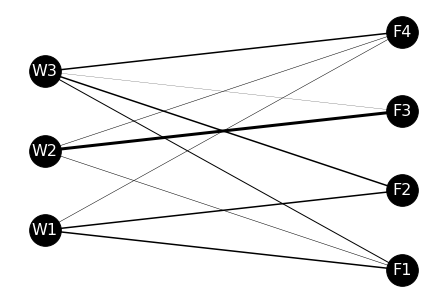

In [14]:
G = nx.Graph()

for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            
            if num_pre<len(G.edges): 
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])
    
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

plt.show()
                

## 운송 비용함수 작성

In [15]:
df_tc = pd.read_csv('trans_cost.csv', index_col='공장') # 각 운송경로의 비용
df_tc

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [16]:
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [17]:
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j] # 운송경로의 운송량 * 비용
    return cost

print("총 운송비용", trans_cost(df_tr, df_tc))

총 운송비용 1493


## 제약조건

In [18]:
df_demand = pd.read_csv('demand.csv') # 공장의 제품 생산량에 대한 수요
df_supply = pd.read_csv('supply.csv') # 창고가 공급 가능한 최대 부품 수

df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [19]:
df_supply

,W1,W2,W3
0,35,41,42


In [20]:
# 수요측 제약 조건
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(df_demand.columns[i], "으로 운송량: ", temp_sum, "( 수요량: ", df_demand.iloc[0][i], ")")
    if temp_sum>=df_demand.iloc[0][i]:
        print("수요량을 만족시키고 있음")
    else:
        print("수요량을 만족시키지 못하고 있음. 운송경로 재계산 필요")

# 공급측 제약 조건
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(df_supply.columns[i], "부터의 운송량:", temp_sum, "( 공급한계: ", df_supply.iloc[0][i], ")")
    
    if temp_sum <= df_supply.iloc[0][i]:
        print("공급한계 범위 내")
    
    else:
        print("공급한계 초과. 운송경로 재계산 필요")

F1 으로 운송량:  30 ( 수요량:  28 )
수요량을 만족시키고 있음
F2 으로 운송량:  30 ( 수요량:  29 )
수요량을 만족시키고 있음
F3 으로 운송량:  32 ( 수요량:  31 )
수요량을 만족시키고 있음
F4 으로 운송량:  25 ( 수요량:  25 )
수요량을 만족시키고 있음
W1 부터의 운송량: 35 ( 공급한계:  35 )
공급한계 범위 내
W2 부터의 운송량: 40 ( 공급한계:  41 )
공급한계 범위 내
W3 부터의 운송량: 42 ( 공급한계:  42 )
공급한계 범위 내


## 운송경로를 변경해서 운송 비용함수 변화 확인

In [21]:
df_tr_new = pd.read_csv("trans_route_new.csv", index_col="공장") # W1에서 F4로의 운송을 줄이고 W2에서 F4로의 운송으로 보충
print("총 운송비용", trans_cost(df_tr_new, df_tc))
df_tr_new

총 운송비용 1428


,F1,F2,F3,F4
공장,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [22]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [23]:
df_supply

,W1,W2,W3
0,35,41,42


In [24]:
# 제약조건 계산 함수

# 수요측
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 공급측
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if (temp_sum<=df_supply.iloc[0][i]):
            flag[i] = 1
    return flag

In [25]:
print("수요조건", condition_demand(df_tr_new, df_demand))
print("공급조건", condition_supply(df_tr_new, df_supply))

수요조건 [1. 1. 1. 1.]
공급조건 [1. 0. 1.]


## 최적화 계산 라이브러리

PuLP를 사용하여 LP를 푸는 방법

1. 변수(variable)를 정의한다.  
    lowBound 인자는 해당 변수의 하한(lower bound)을 설정. 반대로 상한(upper bound)을 설정하고 싶으면 upBound 인자를 정의.  

2. 문제(problem)를 정의한다.
3. 목적 함수(objective function)를 정의한다.
4. 제약 조건(constraints)을 정의한다.
5. 해결한다.

In [28]:
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [29]:
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

In [30]:
pr

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

In [31]:
v1 = {(i,j):LpVariable('v%d_%d'%(i,j), lowBound=0) for i, j in pr}

In [32]:
v1

{(0, 0): v0_0,
 (0, 1): v0_1,
 (0, 2): v0_2,
 (0, 3): v0_3,
 (1, 0): v1_0,
 (1, 1): v1_1,
 (1, 2): v1_2,
 (1, 3): v1_3,
 (2, 0): v2_0,
 (2, 1): v2_1,
 (2, 2): v2_2,
 (2, 3): v2_3}

In [33]:
# 수리 모델 작성 

m1 = model_min() # 정의하는 목적함수를 제약조건 하에서 최소화
v1 = {(i,j):LpVariable('v%d_%d'%(i,j), lowBound=0) for i, j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr) # 목적함수 정의
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i] # 제약조건
    
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j] # 제약조건
    
m1.solve() # 변수 v1이 최적화되고 최적의 총 운송 비용이 구해짐

# 총 운송 비용 계산

df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("총 운송 비용:", total_cost)
    

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용: 1296.0


## 계산된 최적 운송 경로 시각화

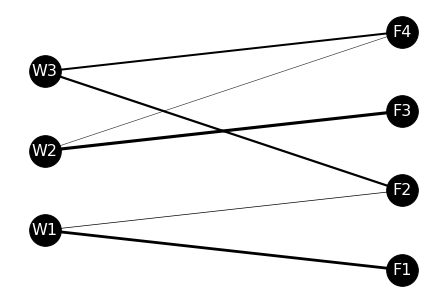

In [37]:
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

G = nx.Graph()

for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
num_pre = 0
edge_weights = []
size = 0.1

for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            
            if num_pre<len(G.edges):
                num_pre=len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif (df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])
    
nx.draw(G, pos, with_labels=True, font_size = 16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

plt.show()

# 생산계획

In [38]:
df_material = pd.read_csv('product_plan_material.csv', index_col='제품')
print(df_material) # 생산하는 제품과 그것들을 제조하는데 필요한 원료의 비율

df_profit = pd.read_csv('product_plan_profit.csv', index_col='제품')
print(df_profit) # 각 제품의 이익(판매가격-판매원가)

df_stock = pd.read_csv('product_plan_stock.csv', index_col='항목')
print(df_stock) # 각 원료의 재고

df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan) # 제품 생산량

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


## 목적함수(이익 계산) 정의

In [39]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
        return profit
    
print("총 이익: ", product_plan(df_profit, df_plan))

총 이익:  80.0


## 목적함수 최대화

In [44]:
v1 = {(i):LpVariable('v%d'%i, lowBound=0) for i in range(len(df_profit))}
v1.items()

dict_items([(0, v0), (1, v1)])

In [43]:
df_material

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


In [47]:
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%i, lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:, i]
m.solve()

df_plan_sol = df_plan.copy()
for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
    
print(df_plan_sol)
print("총 이익:", value(m.objective))
    

      생산량
제품       
제품1    15
제품2     5
총 이익: 95.0


In [48]:
def condition_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum += df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i],"사용량:", temp_sum, "재고", float(df_stock.iloc[0][i]))
    return flag

print("제약 조건 계산 결과:", condition_stock(df_plan_sol, df_material, df_stock))

원료1 사용량: 25.0 재고 40.0
원료2 사용량: 80.0 재고 80.0
원료3 사용량: 50.0 재고 50.0
제약 조건 계산 결과: [1. 1. 1.]


# 운송경로와 생산계획 동시에 고려하기
운송비용과 제조비용이 수요를 만족하면서 최소가 되게

In [8]:
제품 = list('AB')
수요지 = list('PQ')
공장 = list('XY')
레인 = (2, 2)

# 운송비
tbdi = pd.DataFrame(((j,k) for j in 수요지 for k in 공장),
                    columns =['수요지', '공장'])
tbdi['운송비'] = [1, 2, 3, 1]
print(tbdi)

# 수요
tbde = pd.DataFrame(((j,i) for j in 수요지 for i in 제품), columns=['수요지', '제품'])
tbde['수요'] = [10, 10, 20, 20]
print(tbde)

# 생산
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k, nl in zip(공장, 레인) for l
                    in range(nl) for i in 제품), columns=['공장', '레인', '제품', '하한', '상한'])
tbfa['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace=True)
tbfa.loc[4, '상한']=10
tbfa

  수요지 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  수요지 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20


,공장,레인,제품,하한,상한,생산비
0,X,0,A,0,inf,1.0
3,X,1,B,0,inf,1.0
4,Y,0,A,0,10.0,3.0
6,Y,1,A,0,inf,5.0
7,Y,1,B,0,inf,3.0


In [30]:
from ortoolpy import logistics_network

_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa, dep='수요지', dem='수요',
                               fac='공장', prd='제품', tcs='운송비', pcs='생산비', 
                               lwb = '하한', upb='상한')
tbfa

C:\Users\ooroo\anaconda3\lib\site-packages\ortoolpy\etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000048,20.0
3,X,1,B,0,inf,1.0,v000049,10.0
4,Y,0,A,0,10.0,3.0,v000050,10.0
6,Y,1,A,0,inf,5.0,v000051,0.0
7,Y,1,B,0,inf,3.0,v000052,20.0


In [31]:
tbdi2

,수요지,공장,운송비,제품,VarX,ValX
0,P,X,1,A,v000040,10.0
1,P,X,1,B,v000041,10.0
2,Q,X,3,A,v000042,10.0
3,Q,X,3,B,v000043,0.0
4,P,Y,2,A,v000044,0.0
5,P,Y,2,B,v000045,0.0
6,Q,Y,1,A,v000046,10.0
7,Q,Y,1,B,v000047,20.0


## 최적 네트워크의 운송비용 계산

In [12]:
tbdi2 = tbdi2[['공장', '수요지', '운송비', '제품', 'VarX', 'ValX']]
tbdi2

,공장,수요지,운송비,제품,VarX,ValX
0,X,P,1,A,v000014,10.0
1,X,P,1,B,v000015,10.0
2,X,Q,3,A,v000016,10.0
3,X,Q,3,B,v000017,0.0
4,Y,P,2,A,v000018,0.0
5,Y,P,2,B,v000019,0.0
6,Y,Q,1,A,v000020,10.0
7,Y,Q,1,B,v000021,20.0


In [15]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2['운송비'].iloc[i]*tbdi2['ValX'].iloc[i]

print('총 운송비:', trans_cost)

총 운송비: 80.0


## 최적 네트워크의 생산비용 계산

In [16]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000022,20.0
3,X,1,B,0,inf,1.0,v000023,10.0
4,Y,0,A,0,10.0,3.0,v000024,10.0
6,Y,1,A,0,inf,5.0,v000025,0.0
7,Y,1,B,0,inf,3.0,v000026,20.0


In [17]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa['생산비'].iloc[i]*tbfa["ValY"].iloc[i]
    
print("총 생산비:", product_cost)

총 생산비: 120.0
